In [1]:
%pylab inline

from library import lasagnennet as LN
from library import features as F
from library import scale as S
from library import validate as V
import numpy as np
import theano as TH
import pandas as pa
import lasagne as L

Populating the interactive namespace from numpy and matplotlib


Using gpu device 0: Tesla K20m (CNMeM is disabled)


In [2]:
train_feats = pa.read_csv('win_train_feats.csv')
train_targets = pa.read_csv('win_train_targets.csv')
val_feats = pa.read_csv('win_validation_feats.csv')
val_targets = pa.read_csv('win_validation_targets.csv')
vval_feats = pa.read_csv('win_val_train_feats.csv')
vval_targets = pa.read_csv('win_val_train_targets.csv')

In [3]:
print train_targets.columns

Index([u'ID', u'TIME', u'LABEL', u'ICU'], dtype='object')


In [3]:
tx = np.asarray(train_feats, dtype=np.float32)
tyall = np.asarray(train_targets, dtype=np.float32)
ty = np.asarray(train_targets['LABEL'], dtype=np.float32).reshape(-1, 1)
vx = np.asarray(val_feats, dtype=np.float32)
vyall = np.asarray(val_targets, dtype=np.float32)
vy = np.asarray(val_targets['LABEL'], dtype=np.float32).reshape(-1, 1)

In [4]:
valx = np.asarray(vval_feats, dtype=np.float32)
valyall = np.asarray(vval_targets, dtype=np.int64)

In [5]:
print tx.shape, tyall.shape, ty.shape, vx.shape, vyall.shape, vy.shape, valx.shape, valyall.shape

(481571, 321) (481571, 4) (481571, 1) (146866, 321) (146866, 4) (146866, 1) (199971, 321) (199971, 3)


In [49]:
reload(LN)
nneta = LN.nnet(n_in=321, n_out=1, h_layers=[200,100],
                i_drop=None, l_drops=[0.3,0.3], lam=0.0001,
                nonlinearity=L.nonlinearities.sigmoid
           )
nneta.train2(x=tx, y=ty, lrate=0.1, gamma=0.9, batch_size=1000, iters=1000,
            testx=vx, testy=vy, filename='model.npz', change_iters=50
           )

Training ... 
Iteration 0, Loss = 0.0636082938041
Testing ...
[ 0.79487032  0.79489094  0.79489845 ...,  0.79135108  0.7912159
  0.79115719]
Mean auc = 0.399856797079
Iteration 1, Loss = 0.0518683758854
Iteration 2, Loss = 0.0458472050819
Iteration 3, Loss = 0.0412768308514
Iteration 4, Loss = 0.0375781331281
Iteration 5, Loss = 0.0345464382723
Iteration 6, Loss = 0.0320728938308
Iteration 7, Loss = 0.0300431300604
Iteration 8, Loss = 0.0283794662108
Iteration 9, Loss = 0.0270115482115
Iteration 10, Loss = 0.0258897919733
Testing ...
[ 0.94751167  0.94751352  0.94751275 ...,  0.94693166  0.94691873
  0.94690174]
Mean auc = 0.633755223694
Iteration 11, Loss = 0.0249649731682
Iteration 12, Loss = 0.0242038789665
Iteration 13, Loss = 0.0235744792914
Iteration 14, Loss = 0.0230583905308
Iteration 15, Loss = 0.0226317861763
Iteration 16, Loss = 0.0222797094114
Iteration 17, Loss = 0.0219884529455
Iteration 18, Loss = 0.0217482097625
Iteration 19, Loss = 0.0215499160069
Iteration 20, Loss = 

KeyboardInterrupt: 

In [50]:
nnetb = LN.nnet(n_in=321, n_out=1, h_layers=[200,100],
                i_drop=None, l_drops=[0.3,0.3], lam=0.0,
                nonlinearity=L.nonlinearities.sigmoid
           )
nnetb.loadmodel('model.npz')

In [51]:
try:
    nnetb.test(0,0,0)
except:
    pass

Testing ...


In [52]:
probs = nnetb.tester(tx)[0].ravel()
vprobs = nnetb.tester(vx)[0].ravel()
valprobs = nnetb.tester(valx)[0].ravel()
print probs

[ 0.9302848   0.93027025  0.9305523  ...,  0.93046045  0.93044597
  0.93046939]


0.769901436687
0.789301693708


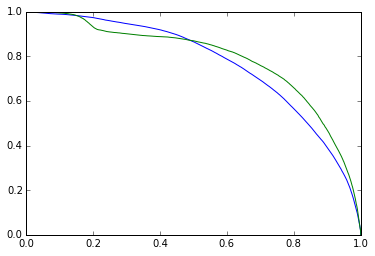

In [53]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

yscore = probs
print roc_auc_score(ty, yscore)
fpr, tpr, thresh = roc_curve(ty, yscore)
pyplot.plot(1-fpr, tpr)
# pyplot.axis('equal')

yscore = vprobs
print roc_auc_score(vy, yscore)
fpr, tpr, thresh = roc_curve(vy, yscore)
pyplot.plot(1-fpr, tpr)
# pyplot.axis('equal')

In [68]:
thresh = np.percentile(valprobs, 99.9)
print thresh
pred = np.int32(valprobs >= thresh)
print np.sum(pred)

outfile = open('output.csv', 'w')
# outfile.write('ID,TIME,LABEL\n')
for i in xrange(valx.shape[0]):
    if np.int64(valyall[i,2]) == 1:
        outfile.write(str(valyall[i,0])+','+str(valyall[i,1])+','+str(pred[i])+'\n')
outfile.close()

0.93085694313
202


In [64]:
thresh = np.percentile(vprobs.ravel(), 99.8)
# thresh = 0.93
print thresh
pred = np.int32(vprobs.ravel() >= thresh)
print np.sum(pred)

outfile = open('out.csv', 'w')
outfile.write('ID,TIME,LABEL,ICU\n')
for i in xrange(vx.shape[0]):
    if np.int32(vyall[i,3]) == 1.0:
        outfile.write(str(vyall[i,0])+','+str(vyall[i,1])+','+str(pred[i])+',1\n')
outfile.close()

0.930841239691
294


In [65]:
reload(V)
V.validate('out.csv', './Training_Dataset/id_label_train.csv')

tp :  12 , tn :  808 , fp :  6 , fn :  44
sensitivity :  0.214285714286 , specificity :  0.992628992629
accuracy :  0.942528735632 median prediction time :  59.4166666667
finalScore :  33.8905545156


(0.21428571428571427,
 0.9926289926289926,
 0.9425287356321839,
 59.416666666666664,
 33.89055451555451)